# Sprawozdanie z laboratorium 4

***Autor: Adam Dąbkowski***

Celem czwartego laboratorium jest zaimplementowanie drzew decyzyjnych tworzonych algorytmem ID3 z ograniczeniem maksymalnej głębokości drzewa. Dodatkowo należy wykorzystać algorytm do stworzenia i zbadania jakości klasyfikatorów dla zbioru danych ***Cardio Vascular Disease Detection***.


## 0. Importowanie niezbędnych bibliotek

In [51]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from pprint import pprint
import matplotlib.pyplot as plt

## 1. Przygotowanie danych

Dane, na których będziemy testowali naszą implementację drzew decyzyjnych tworzonych algorytmem ID3, jest zbiór ***Cardio Vascular Disease Detection***. Jak widać na poniższym listingu, niektóre atrybuty ***(age, weight, height, ap_hi, ap_lo)*** nie są dyskretne, dlatego pierwszym krokiem, który należy wykonać, jest dyskretyzacja, poprzez podzielenie wartości na zakresy. Oprócz tego dane, na których będziemy pracować, zostają pozbawione atrybuty ***id***, który w tym przypadku jest niepotrzebny.

In [52]:
data = pd.read_csv("./data/cardio_train.csv", sep=';')
data.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,988,22469,1,155,69.0,130,80,2,2,0,0,1,0
1,989,14648,1,163,71.0,110,70,1,1,0,0,1,1
2,990,21901,1,165,70.0,120,80,1,1,0,0,1,0
3,991,14549,2,165,85.0,120,80,1,1,1,1,1,0
4,992,23393,1,155,62.0,120,80,1,1,0,0,1,0


In [53]:
data.drop(["id"], axis=1, inplace=True)

In [54]:
data["age"] = data["age"].apply(lambda x: "young" if x < 20 * 365 else "middle" if x < 60 * 365 else "old")
data["height"] = data["height"].apply(lambda x: "low" if x < 165 else "middle" if x < 190 else "tall")
data["weight"] = data["weight"].apply(lambda x: "skinny" if x < 60 else "middle" if x < 100 else "fat")
data["ap_hi"] = data["ap_hi"].apply(lambda x: "low" if x < 110 else "normal" if x < 130 else "high")
data["ap_lo"] = data["ap_lo"].apply(lambda x: "low" if x < 75 else "normal" if x < 85 else "high")

In [55]:
data.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,old,1,low,middle,high,normal,2,2,0,0,1,0
1,middle,1,low,middle,normal,low,1,1,0,0,1,1
2,old,1,middle,middle,normal,normal,1,1,0,0,1,0
3,middle,2,middle,middle,normal,normal,1,1,1,1,1,0
4,old,1,low,middle,normal,normal,1,1,0,0,1,0


W analizowanym przez nas zbiorze klasą jest pole ***cardio***. Mając to na uwadze, możemy podzielić nasze na dwa zbiory: zbiór ***X*** (przestrzeń wejść) i zbiór ***y*** (przestrzeń wyjść). Dodatkowo poprzez zastosowanie ***dropna*** usuwane są wiersze z brakującymi danymi.

In [56]:
target_label = "cardio"

In [57]:
data.dropna(inplace=True)

In [58]:
y = data.loc[:, data.columns.isin([target_label])]
X = data.drop([target_label], axis=1)

In [59]:
X.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,old,1,low,middle,high,normal,2,2,0,0,1
1,middle,1,low,middle,normal,low,1,1,0,0,1
2,old,1,middle,middle,normal,normal,1,1,0,0,1
3,middle,2,middle,middle,normal,normal,1,1,1,1,1
4,old,1,low,middle,normal,normal,1,1,0,0,1


In [60]:
y.head()

,cardio
0,0
1,1
2,0
3,0
4,0


Ostatnim krokiem jest podział ***X*** i ***y*** na zbiory: treningowy (*train*), walidacyjny (*val*) i testowy (*test*). Podczas podziału istotne są proporcje, w których utworzone zostaną nowe zbiory. Oczywiście większość danych powinniśmy przydzielić do zbioru treningowego, jednakże utworzenie zbyt małych zbiorów walidacyjnych i testowych może spowodować, że ocena modelu nie będzie odzwierciedlała jego faktycznej jakości, ponieważ o tym, czy dany model będzie dobry lub zły decydować będzie w głównej dobór elementów zawartych w zbiorach. Dlatego, aby się przed tym zabezpieczyć, nasz zbiór treningowy zawierał będzie **70%** danych, natomiast walidacyjny i testowy po **15%**.

In [61]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, train_size=0.7, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

## 2. Implementacja algorytmu drzew decyzyjnych tworzonych algorytmem ID3

Głównym zadaniem czwartego laboratorium jest implementacja drzew decyzyjnych tworzonych algorytmem ID3 z ograniczeniem maksymalnej głębokości drzewa. W tym celu stworzona została klasa ***ID3Solver***. Podczas tworzenia obiektu tej klasy istnieje możliwość podania parametru ***depth***, który ustala maksymalną głębokość drzewa:


Klasa ***ID3Solver*** zawiera także osiem metod:
- ***get_parameters()*** - metoda zwracająca wartość parametru ***depth***
- ***fit()*** - metoda, której wywołanie rozpoczyna proces tworzenia modelu
- ***get_entropy()*** - metoda wyznaczająca wartość entropii
- ***get_info_gain()*** - metoda zwracająca zdobycz informacyjną
- ***get_decision_feature()*** - metoda wyznaczająca atrybut, względem którego nastąpi kolejny podział
- ***create_tree()*** - metoda, która tworzy drzewo
- ***predict_item()*** - metoda odpowiedzialna za predykcję pojedynczego elementu
- ***predict()*** - metoda odpowiedzialna za predykcję wszystkich dostarczonych elementów

In [62]:
class ID3Solver():
    def __init__(self, depth=1):
        self.target_label = None
        self.tree = None
        self.depth = depth

    def get_parameters(self):
        return {
            "depth": self.depth
        }

    def fit(self, X, y):
        self.target_label = y.columns.values[0]
        X[self.target_label] = y
        X.dropna(inplace=True)
        self.tree = self.create_tree(X, self.depth)

    def get_entropy(self, feature_data):
        feature_elements, feature_counts = np.unique(feature_data, return_counts=True)
        entropy = np.sum(
            [(-feature_counts[i] / np.sum(feature_counts)) * np.log2(feature_counts[i] / np.sum(feature_counts)) for i
             in range(len(feature_elements))])
        return entropy

    def get_info_gain(self, data, decision_feature):
        total_entropy = self.get_entropy(data[self.target_label])
        feature_values, feature_counts = np.unique(data[decision_feature], return_counts=True)

        for i in range(len(feature_values)):
            probability = feature_counts[i] / np.sum(feature_counts)
            feature_data = data[data[decision_feature] == feature_values[i]][self.target_label]
            total_entropy -= self.get_entropy(feature_data) * probability

        return total_entropy

    def get_decision_feature(self, data):
        features = data.columns.drop(self.target_label)
        info_gain_values = [self.get_info_gain(data, feature) for feature in features]
        decision_feature = features[np.argmax(info_gain_values)]
        return decision_feature

    def create_tree(self, data, depth):
        if data.shape[0] == 0:
            return {}

        if depth == 0:
            return data[self.target_label].value_counts().idxmax()

        if len(np.unique(data[self.target_label])) == 1:
            return np.unique(data[self.target_label])[0]

        decision_feature = self.get_decision_feature(data)

        tree = {decision_feature: {}}

        for feature_value in np.unique(data[decision_feature]):
            subset = data[data[decision_feature] == feature_value]
            subset.pop(decision_feature)
            subtree = self.create_tree(subset, depth - 1)
            tree[decision_feature][feature_value] = subtree

        return tree

    def predict_item(self, tree, item):
        if isinstance(tree, dict):
            decision_feature = next(iter(tree))
            value = item[decision_feature]

            if value in tree[decision_feature]:
                return self.predict_item(tree[decision_feature][value], item)
            else:
                return False

        else:
            return tree

    def predict(self, X):
        prediction = []
        for i in range(X.shape[0]):
            prediction.append(self.predict_item(self.tree, X.iloc[i]))
        return prediction

## 3. Implementacja funkcji pomocniczych

Aby usprawnić analizę otrzymanych wyników, zaimplementowane zostały funkcje pomocnicze ***get_metrics()*** , ***plot_history()*** , ***plot_confusion_matrix()*** oraz ***determine_the_best_model()*** . Pierwsza z nich zwraca wyniki poszczególnych metryk takich jak: dokładność, precyzja, pełność i wynik $F_1$, druga wyświetla wykres obrazujący wpływ głębokości na uzyskane wyniki, trzecia wyznacza macierz pomyłek dla zbioru testowego, natomiast czwarta umożliwia znalezienie najlepszego modelu, badając wpływ maksymalnej głębokości drzewa.

In [63]:
def get_metrics(y_true, y_pred, printing=True):
    accuracy = metrics.accuracy_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    f1_score = metrics.f1_score(y_true, y_pred)

    if printing:
        print("Accuracy: ", accuracy)
        print("Precision: ", precision)
        print("Recall: ", recall)
        print("F1 score: ", f1_score)

    return [accuracy, precision, recall, f1_score]

In [64]:
def plot_history(train_history, validation_history, metric):
    plt.figure(figsize=(7, 5))
    plt.plot(train_history, linewidth=2, label="Training set")
    plt.xticks(np.arange(0, len(train_history)), np.arange(1, len(train_history) + 1))
    plt.plot(validation_history, linewidth=2, label="Validation set")
    plt.xticks(np.arange(0, len(validation_history)), np.arange(1, len(validation_history) + 1))
    plt.xlabel('depth', fontsize=12)
    plt.ylabel(f'{metric}', fontsize=12)
    plt.legend(loc="upper left", fontsize=10)
    plt.show()

In [65]:
def plot_confusion_matrix(y_test, y_pred):
    cf_matrix = metrics.confusion_matrix(y_test, y_pred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    sns.heatmap(cf_matrix, center=True, annot=labels, fmt="", cmap='viridis')
    plt.title("Confusion matrix for test set")
    plt.show()

In [66]:
def determine_the_best_model(X_train, y_train, X_val, y_val, X_test, y_test, depth_range=11, main_metric="f1_score", print_model=False, plot_results=True, plot_conf_matrix=True):
    best_model = None
    best_metric_score = 0
    train_history = []
    validation_history = []

    if main_metric == "accuracy":
        metric_type = 0
    elif main_metric == "precision":
        metric_type = 1
    elif main_metric == "recall":
        metric_type = 2
    elif main_metric == "f1_score":
        metric_type = 3
    else:
        raise "Invalid metric"

    for depth in range(1, depth_range + 1):
        print(f"\nDepth {depth}")
        print(f"--------------------------------------------------------------------------------")

        model = ID3Solver(depth)
        model.fit(X_train, y_train)

        y_pred_train = model.predict(X_train)
        y_pred_val = model.predict(X_val)

        print(f"\nTraining Set")
        metric_score_train = get_metrics(y_train, y_pred_train)[metric_type]

        print(f"\nValidation Set")
        metric_score_val = get_metrics(y_val, y_pred_val)[metric_type]

        train_history.append(metric_score_train)
        validation_history.append(metric_score_val)

        if metric_score_val > best_metric_score:
            best_metric_score = metric_score_val
            best_model = model

    if plot_results:
        plot_history(train_history, validation_history, main_metric)


    print(f"\nBest Model")
    print(f"--------------------------------------------------------------------------------")

    print(f"\nValidation Set")

    if print_model:
        print("Best model: ")
        pprint(best_model.tree)

    print("Best depth: ", best_model.depth)
    print(f"Best {main_metric}: ", best_metric_score)


    print(f"\nTest Set")

    y_pred_test = best_model.predict(X_test)
    get_metrics(y_test, y_pred_test)[metric_type]

    if plot_conf_matrix:
        plot_confusion_matrix(y_test, y_pred_test)

    return best_model

## 4. Zastosowanie algorytmu

Mając zaimplementowaną klasę ***ID3Solver*** oraz funkcje analizujące otrzymywane wyniki, możemy przejść do przeprowadzenia szeregu doświadczeń polegających na poszukiwaniu najlepszego modelu, który umożliwia uzyskanie najlepszej jakości predykcji na zbiorze testowym. Wybór najlepszego modelu jest powiązany z możliwą maksymalną głębokością drzewa. Nasze rozważania zostały przeprowadzone dla różnych proporcji podziału zbioru danych na zbiory treningowy, walidacyjny i testowy. Na początku skorzystamy z podziału, w którym zbiór treningowy zawiera **70%** danych, natomiast walidacyjny i testowy po **15%**.


Depth 1
--------------------------------------------------------------------------------

Training Set
Accuracy:  0.7139146567717997
Precision:  0.7600362665592102
Recall:  0.6234351113498326
F1 score:  0.684991828581805

Validation Set
Accuracy:  0.7176527176527177
Precision:  0.7624245239201115
Recall:  0.631953801732435
F1 score:  0.6910851489316914

Depth 2
--------------------------------------------------------------------------------

Training Set
Accuracy:  0.7260977118119976
Precision:  0.7511272660347842
Recall:  0.6745031607651943
F1 score:  0.7107560354398416

Validation Set
Accuracy:  0.7297739297739297
Precision:  0.7521132713440406
Recall:  0.6850818094321462
F1 score:  0.717034350760552

Depth 3
--------------------------------------------------------------------------------

Training Set
Accuracy:  0.7264069264069264
Precision:  0.7473188832073849
Recall:  0.6823534272610834
F1 score:  0.7133601140339509

Validation Set
Accuracy:  0.7302549302549303
Precision:  0.7486

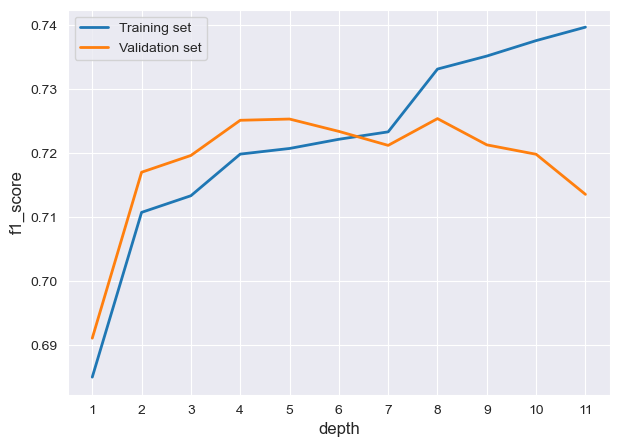


Best Model
--------------------------------------------------------------------------------

Validation Set
Best depth:  8
Best f1_score:  0.7254178002331908

Test Set
Accuracy:  0.721816083108888
Precision:  0.7319936331078393
Recall:  0.7042496171516079
F1 score:  0.7178536585365853


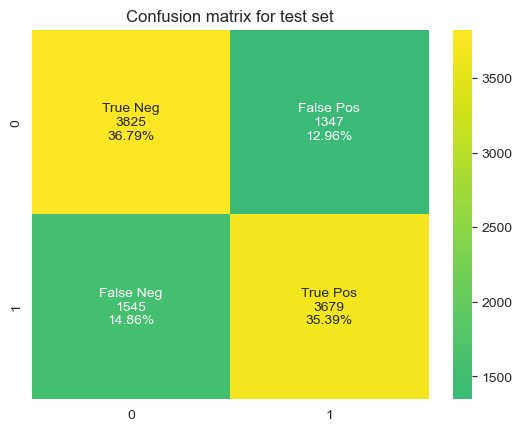

In [67]:
best_model_1_f1 = determine_the_best_model(
                         X_train=X_train,
                         y_train=y_train,
                         X_val=X_val,
                         y_val=y_val,
                         X_test=X_test,
                         y_test=y_test,
                         depth_range=11,
                         main_metric='f1_score',
                         print_model=False,
                         plot_results=True,
                         plot_conf_matrix=True
                         )

In [84]:
best_model_1_f1.get_parameters()

{'depth': 8}

Do oceny jakości klasyfikatorów zostanie wykorzystany wynik $F_1$ ($F_1$ ***score***). Jest to swoisty kompromis pomiędzy precyzją (***precision***), a pełnością (***recall***). Dzięki zastosowaniu tej miary wydajności zabezpieczamy się przed wypaczonymi zbiorami danych, czyli tymi, w których niektóre klasy występują znacznie częściej od pozostałych, czego nie możemy powiedzieć w przypadku zastosowania dokładności (***accuracy***).

Stosując różne miary wydajności, może zdarzyć się tak, że najlepszy otrzymany model nie jest tym, który został wyznaczony stosując drugą z miar, co widzimy poniżej.


Depth 1
--------------------------------------------------------------------------------

Training Set
Accuracy:  0.7139146567717997
Precision:  0.7600362665592102
Recall:  0.6234351113498326
F1 score:  0.684991828581805

Validation Set
Accuracy:  0.7176527176527177
Precision:  0.7624245239201115
Recall:  0.631953801732435
F1 score:  0.6910851489316914

Depth 2
--------------------------------------------------------------------------------

Training Set
Accuracy:  0.7260977118119976
Precision:  0.7511272660347842
Recall:  0.6745031607651943
F1 score:  0.7107560354398416

Validation Set
Accuracy:  0.7297739297739297
Precision:  0.7521132713440406
Recall:  0.6850818094321462
F1 score:  0.717034350760552

Depth 3
--------------------------------------------------------------------------------

Training Set
Accuracy:  0.7264069264069264
Precision:  0.7473188832073849
Recall:  0.6823534272610834
F1 score:  0.7133601140339509

Validation Set
Accuracy:  0.7302549302549303
Precision:  0.7486

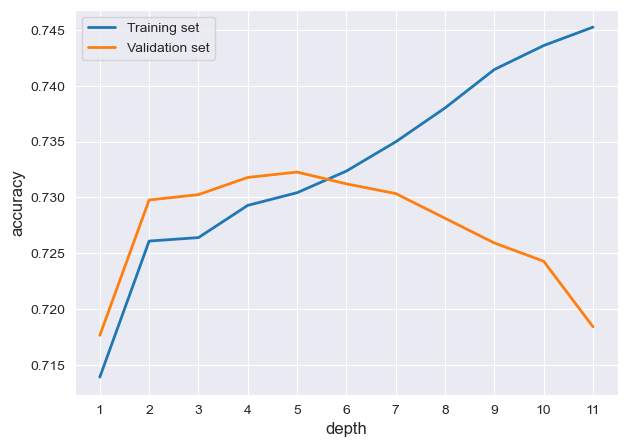


Best Model
--------------------------------------------------------------------------------

Validation Set
Best depth:  5
Best accuracy:  0.7322751322751323

Test Set
Accuracy:  0.7243170450173143
Precision:  0.7434944237918215
Recall:  0.6891271056661562
F1 score:  0.7152791575601034


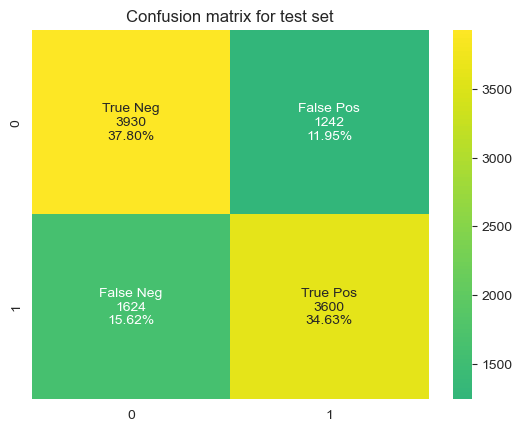

In [68]:
best_model_1_acc = determine_the_best_model(
                         X_train=X_train,
                         y_train=y_train,
                         X_val=X_val,
                         y_val=y_val,
                         X_test=X_test,
                         y_test=y_test,
                         depth_range=11,
                         main_metric='accuracy',
                         print_model=False,
                         plot_results=True,
                         plot_conf_matrix=True
                         )

Widzimy, że w przypadku zastosowania wyniku $F_1$ najlepszy model osiągnęliśmy dla głębkości ***depth*** = 8, natomiast korzystając z dokładności, głębokość jest równa 5.

Aby porównać ze sobą w ten sposób uzyskane modele, wykorzystana zostanie macierz pomyłek. Macierz ta zawiera informacje ile próbek zostało rozpoznanych prawdziwie negatywnie (***True Neg***), fałszywie pozytywnie (***False Pos***), fałszywie negatywnie (***False Neg***) oraz prawdziwie pozytywnie (***True Pos***). Analizując otrzymane powyżej macierze zauważamy, że zarówno w jednym, jak i drugim przypadku dominują próbki prawdziwie negatywne i pozytywne, co jest bardzo dobrą informacją. Widać także, że odchylenia w uzyskanych wynikach nie przekraczają 1,5 pp, co również świadczy o podobieństwie w uzyskanej jakości.

Oprócz wyboru miary wydajności, na jakość klasyfikatora wpływ ma także podział danych na zbiory w odpowiednich proporcjach. Poniżej zamieszczone są wyniki doświadczeń dla różnych proporcji podziału danych.

In [69]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, train_size=0.8, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)


Depth 1
--------------------------------------------------------------------------------

Training Set
Accuracy:  0.7136002886002886
Precision:  0.7605149457719778
Recall:  0.6228336221837089
F1 score:  0.6848227400849577

Validation Set
Accuracy:  0.7171717171717171
Precision:  0.7636998254799302
Recall:  0.630365888792855
F1 score:  0.6906565656565656

Depth 2
--------------------------------------------------------------------------------

Training Set
Accuracy:  0.726010101010101
Precision:  0.7515690376569037
Recall:  0.674501733102253
F1 score:  0.7109529608768459

Validation Set
Accuracy:  0.7313131313131314
Precision:  0.7572753437799808
Recall:  0.6822241428983002
F1 score:  0.7177932706880874

Depth 3
--------------------------------------------------------------------------------

Training Set
Accuracy:  0.7262265512265512
Precision:  0.7476654004431782
Recall:  0.6822284806470248
F1 score:  0.7134496299652621

Validation Set
Accuracy:  0.732034632034632
Precision:  0.75377

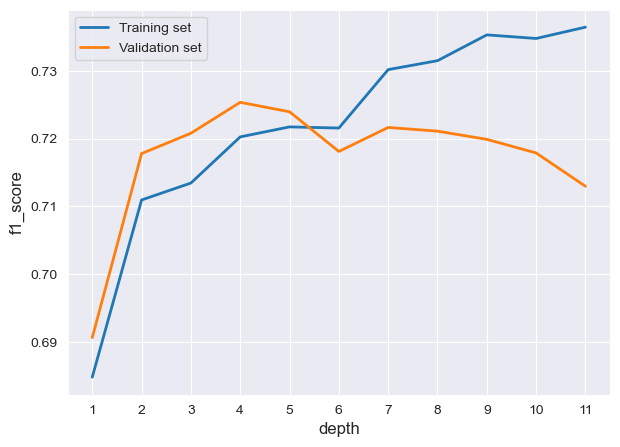


Best Model
--------------------------------------------------------------------------------

Validation Set
Best depth:  4
Best f1_score:  0.725356294536817

Test Set
Accuracy:  0.7238493723849372
Precision:  0.7352671755725191
Recall:  0.6969609261939218
F1 score:  0.7156017830609211


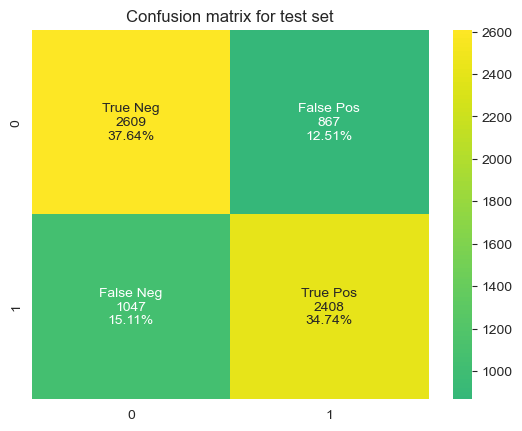

In [70]:
best_model_2 = determine_the_best_model(
                         X_train=X_train,
                         y_train=y_train,
                         X_val=X_val,
                         y_val=y_val,
                         X_test=X_test,
                         y_test=y_test,
                         depth_range=11,
                         main_metric='f1_score',
                         print_model=False,
                         plot_results=True,
                         plot_conf_matrix=True
                         )

In [71]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, train_size=0.9, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)


Depth 1
--------------------------------------------------------------------------------

Training Set
Accuracy:  0.7137085137085137
Precision:  0.7608312095667517
Recall:  0.6227335451365489
F1 score:  0.6848904104754173

Validation Set
Accuracy:  0.7105339105339106
Precision:  0.750524109014675
Recall:  0.6244186046511628
F1 score:  0.68168835290384

Depth 2
--------------------------------------------------------------------------------

Training Set
Accuracy:  0.726374859708193
Precision:  0.7521737574694959
Recall:  0.6745932415519399
F1 score:  0.7112742775935575

Validation Set
Accuracy:  0.7238095238095238
Precision:  0.7434588385449904
Recall:  0.6773255813953488
F1 score:  0.7088530574992394

Depth 3
--------------------------------------------------------------------------------

Training Set
Accuracy:  0.7268077601410935
Precision:  0.7483294647253288
Recall:  0.6828407304001797
F1 score:  0.7140867522443158

Validation Set
Accuracy:  0.7232323232323232
Precision:  0.73855

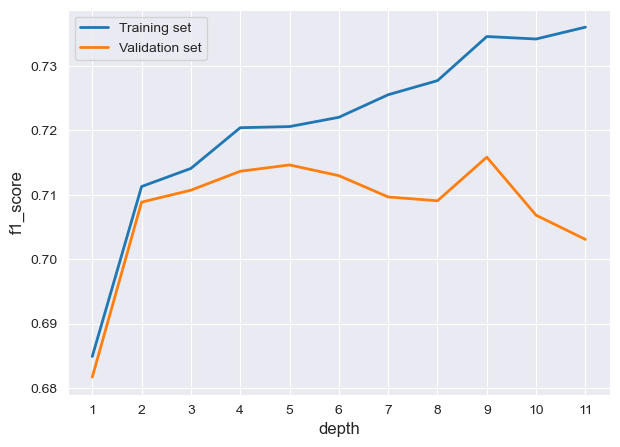


Best Model
--------------------------------------------------------------------------------

Validation Set
Best depth:  9
Best f1_score:  0.7158326016973954

Test Set
Accuracy:  0.7308136180034622
Precision:  0.7354312354312355
Recall:  0.7248707639287766
F1 score:  0.7301128145791149


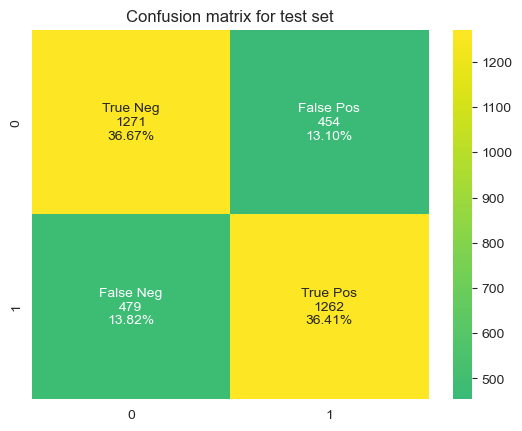

In [72]:
best_model_3 = determine_the_best_model(
                         X_train=X_train,
                         y_train=y_train,
                         X_val=X_val,
                         y_val=y_val,
                         X_test=X_test,
                         y_test=y_test,
                         depth_range=11,
                         main_metric='f1_score',
                         print_model=False,
                         plot_results=True,
                         plot_conf_matrix=True
                         )

In [73]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, train_size=0.6, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)


Depth 1
--------------------------------------------------------------------------------

Training Set
Accuracy:  0.7138287638287638
Precision:  0.7589123157338346
Recall:  0.6237690673875266
F1 score:  0.6847362424820497

Validation Set
Accuracy:  0.7158730158730159
Precision:  0.7674868189806678
Recall:  0.6254654826697221
F1 score:  0.689236111111111

Depth 2
--------------------------------------------------------------------------------

Training Set
Accuracy:  0.7263347763347764
Precision:  0.750120546477364
Recall:  0.675854412048658
F1 score:  0.7110535537441913

Validation Set
Accuracy:  0.7282106782106782
Precision:  0.7582329317269076
Recall:  0.6760240618733887
F1 score:  0.7147724691451505

Depth 3
--------------------------------------------------------------------------------

Training Set
Accuracy:  0.7268638768638769
Precision:  0.7466139657444005
Recall:  0.6838675419965244
F1 score:  0.713864604066413

Validation Set
Accuracy:  0.7283549783549783
Precision:  0.75422

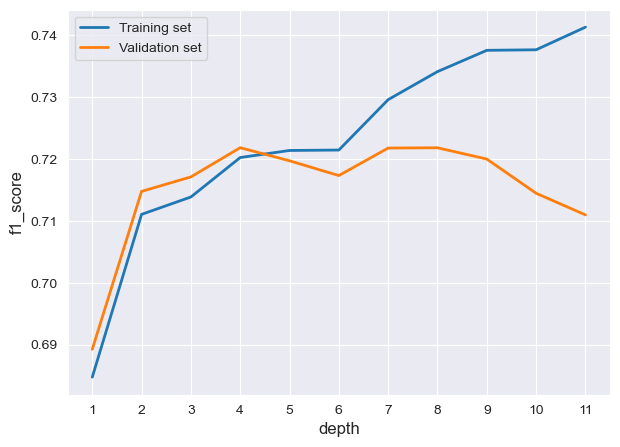


Best Model
--------------------------------------------------------------------------------

Validation Set
Best depth:  4
Best f1_score:  0.7218346445005195

Test Set
Accuracy:  0.7272202582786235
Precision:  0.7415091439987705
Recall:  0.6968515309069901
F1 score:  0.7184870821234458


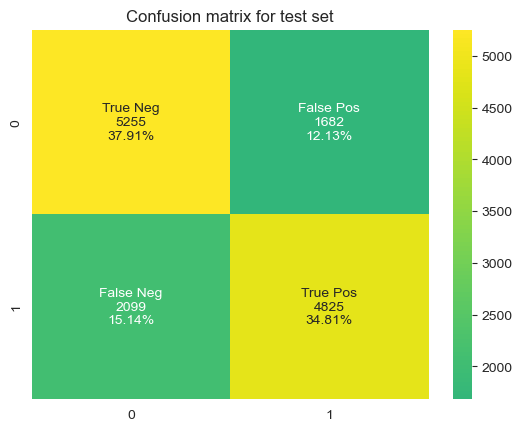

In [74]:
best_model_4 = determine_the_best_model(
                         X_train=X_train,
                         y_train=y_train,
                         X_val=X_val,
                         y_val=y_val,
                         X_test=X_test,
                         y_test=y_test,
                         depth_range=11,
                         main_metric='f1_score',
                         print_model=False,
                         plot_results=True,
                         plot_conf_matrix=True
                         )

In [75]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, train_size=0.5, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)


Depth 1
--------------------------------------------------------------------------------

Training Set
Accuracy:  0.7138816738816739
Precision:  0.7600736491749877
Recall:  0.6218784402340808
F1 score:  0.6840662842574888

Validation Set
Accuracy:  0.7137662337662337
Precision:  0.7580353415889801
Recall:  0.628518689432395
F1 score:  0.6872280037842952

Depth 2
--------------------------------------------------------------------------------

Training Set
Accuracy:  0.7269552669552669
Precision:  0.7518083182640145
Recall:  0.6744886725766267
F1 score:  0.7110527440979751

Validation Set
Accuracy:  0.7249062049062049
Precision:  0.7480925737538149
Recall:  0.6787032764190125
F1 score:  0.7117106218243408

Depth 3
--------------------------------------------------------------------------------

Training Set
Accuracy:  0.7275324675324676
Precision:  0.7477500316896946
Recall:  0.6835853757459877
F1 score:  0.7142295002572873

Validation Set
Accuracy:  0.7246176046176046
Precision:  0.74

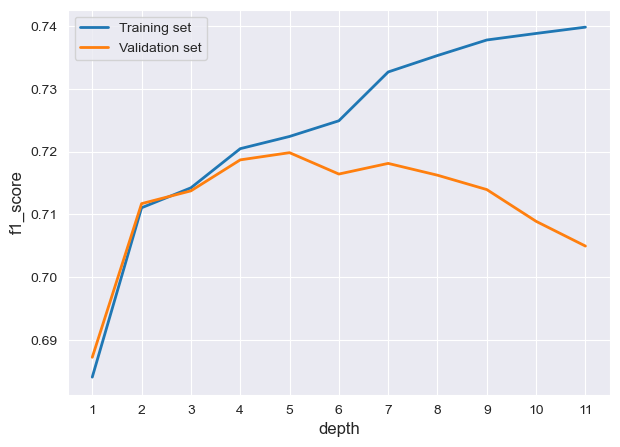


Best Model
--------------------------------------------------------------------------------

Validation Set
Best depth:  5
Best f1_score:  0.7198293737780674

Test Set
Accuracy:  0.7291354034399169
Precision:  0.7459439528023599
Recall:  0.6979873490511789
F1 score:  0.7211692709880578


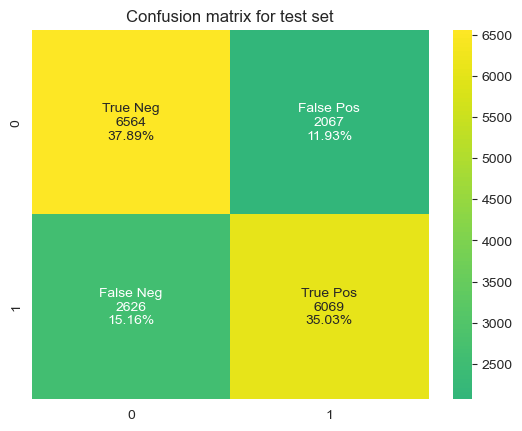

In [76]:
best_model_5 = determine_the_best_model(
                         X_train=X_train,
                         y_train=y_train,
                         X_val=X_val,
                         y_val=y_val,
                         X_test=X_test,
                         y_test=y_test,
                         depth_range=11,
                         main_metric='f1_score',
                         print_model=False,
                         plot_results=True,
                         plot_conf_matrix=True
                         )

In [77]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, train_size=0.333, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)


Depth 1
--------------------------------------------------------------------------------

Training Set
Accuracy:  0.7141742860857131
Precision:  0.759948925303256
Recall:  0.6220170701968298
F1 score:  0.6840996168582376

Validation Set
Accuracy:  0.714563862928349
Precision:  0.7610777812861804
Recall:  0.6256272711541789
F1 score:  0.6867372619782517

Depth 2
--------------------------------------------------------------------------------

Training Set
Accuracy:  0.7269142436191879
Precision:  0.7517496111975117
Recall:  0.6735760320501655
F1 score:  0.7105190629306385

Validation Set
Accuracy:  0.7262028383523711
Precision:  0.7505269208660663
Recall:  0.677798927150026
F1 score:  0.712311329332606

Depth 3
--------------------------------------------------------------------------------

Training Set
Accuracy:  0.7274342418858604
Precision:  0.7467211556738262
Recall:  0.6842884514892876
F1 score:  0.7141428831121615

Validation Set
Accuracy:  0.7256403599861544
Precision:  0.74463

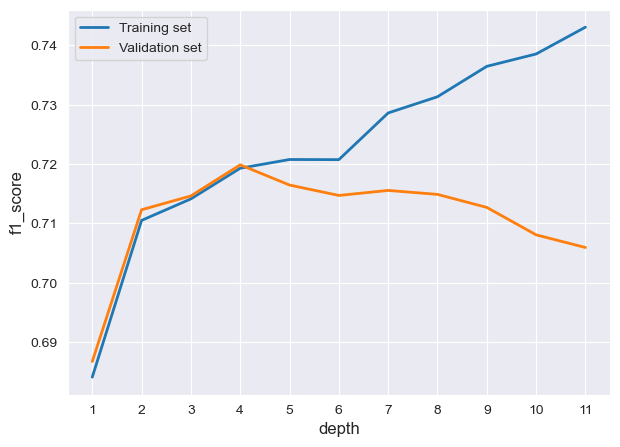


Best Model
--------------------------------------------------------------------------------

Validation Set
Best depth:  4
Best f1_score:  0.7198820744181892

Test Set
Accuracy:  0.7280633437175493
Precision:  0.7459830964985604
Recall:  0.693489898117769
F1 score:  0.7187793637299208


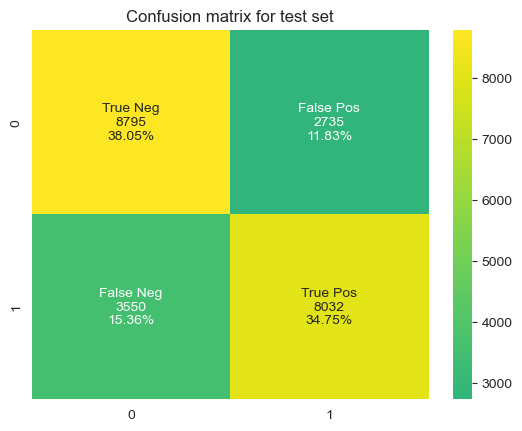

In [78]:
best_model_6 = determine_the_best_model(
                         X_train=X_train,
                         y_train=y_train,
                         X_val=X_val,
                         y_val=y_val,
                         X_test=X_test,
                         y_test=y_test,
                         depth_range=11,
                         main_metric='f1_score',
                         print_model=False,
                         plot_results=True,
                         plot_conf_matrix=True
                         )

In [79]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, train_size=0.1, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)


Depth 1
--------------------------------------------------------------------------------

Training Set
Accuracy:  0.706926406926407
Precision:  0.7457567185289957
Recall:  0.6164864074831921
F1 score:  0.6749879980796928

Validation Set
Accuracy:  0.7143819143819143
Precision:  0.7627454084863838
Recall:  0.6198134448375684
F1 score:  0.6838911168683678

Depth 2
--------------------------------------------------------------------------------

Training Set
Accuracy:  0.7197691197691197
Precision:  0.7383177570093458
Recall:  0.6696872259573224
F1 score:  0.7023298589822196

Validation Set
Accuracy:  0.7267917267917268
Precision:  0.7536650538022677
Recall:  0.6713412672885172
F1 score:  0.7101252041371802

Depth 3
--------------------------------------------------------------------------------

Training Set
Accuracy:  0.7223665223665223
Precision:  0.7373929590865842
Recall:  0.6796258403975446
F1 score:  0.7073319135990265

Validation Set
Accuracy:  0.7259900593233927
Precision:  0.74

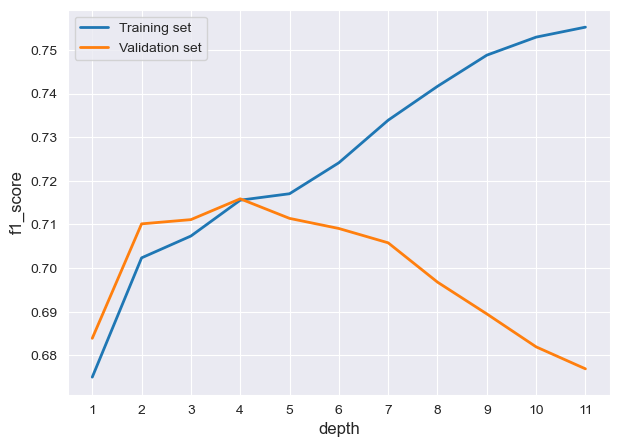


Best Model
--------------------------------------------------------------------------------

Validation Set
Best depth:  4
Best f1_score:  0.715863219349458

Test Set
Accuracy:  0.7296543320720836
Precision:  0.7451645741431965
Recall:  0.7013285641287685
F1 score:  0.7225823434569445


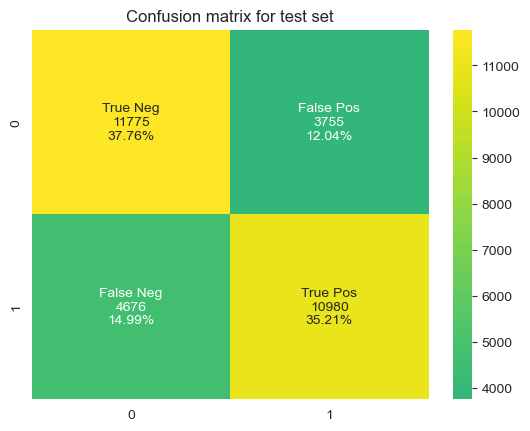

In [80]:
best_model_7 = determine_the_best_model(
                         X_train=X_train,
                         y_train=y_train,
                         X_val=X_val,
                         y_val=y_val,
                         X_test=X_test,
                         y_test=y_test,
                         depth_range=11,
                         main_metric='f1_score',
                         print_model=False,
                         plot_results=True,
                         plot_conf_matrix=True
                         )

## 5. Podsumowanie

Dla zwiększenia czytelności otrzymanych rezultatów, poniżej została zamieszczona zbiorcza tabela, która przedstawia wyniki powyższych doświadczeń. Wielkości zbiorów są przedstawione jako ułamek wszystkich dostępnych danych.

| Wielkość zbioru treningowego | Wielkość zbioru walidacyjnego | Wielkość zbioru testowego | Najlepsza głębokość | Wynik F1 (najlepszy dla zbioru walidacyjnego) | Wynik F1 (dla zbioru testowego) |
|------------------------------|-------------------------------|---------------------------|---------------------|-----------------------------------------------|---------------------------------|
| 0.1                          | 0.4                           | 0.4                       | 4                   | 0.7158632                                     | 0.7225822                       |
| 0.(333)                      | 0.(333)                       | 0.(333)                   | 5                   | 0.7198821                                     | 0.7187794                       |
| 0.5                          | 0.25                          | 0.25                      | 5                   | 0.7198294                                     | 0.7211693                       |
| 0.6                          | 0.2                           | 0.2                       | 4                   | 0.7218346                                     | 0.7184871                       |
| 0.7                          | 0.15                          | 0.15                      | 8                   | 0.7254178                                     | 0.7178537                       |
| 0.8                          | 0.1                           | 0.1                       | 4                   | 0.7253563                                     | 0.7156018                       |
| 0.9                          | 0.05                          | 0.05                      | 9                   | 0.7158326                                     | 0.7301128                       |

Analizując wyniki zamieszczone w powyższej tabeli widzimy, że w zależności od proporcji podziału danych na zbiory obserujemy różne optymalne głębokości. W przypadku, gdy wielkość zbióru uczącego nie jest znacząco większa od wielkości zbiorów walidacyjnego i testowego model znacznie łatwiej przetrenować, co można zaobserować szczególnie na wykresach dla wielkości zbioru treningowego stanowiącego **10%** wszystkich danych oraz dla tego, gdzie zbiór treningowy zawiera **33.33%** danych. W rezulatcie optymalne modele otrzymujemy dla mniejszych głębkości niż ma to miejsce gdy zbiór danych stanowi większość danych. Oczywiście nie zawsze jest to regułą, co możemy zaobserować w sytuacji gdy zbiór treningowy posiada **80%** danych.

Mając na uwadze tablę, możemy stwierdzić, że najlepszy rezultat, czyli wynik $F_1$ dla zbioru testowego, który wynosi **0,7301128** otrzymujemy, gdy zbiór treningowy składa się z **90%** danych, natomiast zbiór walidacyjny i testowy z **5%**. Wynik ten uzyskany został przy maksymalnej głębokości drzewa równej **9**. Jednakże nie możemy być pewni, że model ten w przypadku nowych danych testowych również osiągnie podobny wynik. Jest to spowodowane tym, że wielkość zbiorów walidycyjnego i testowego jest zbyt mała w stosunku do wielkości zbioru treningowego, przez co finalny wynik w dużym stopniu zależy od sposobu rozdysponowania danych do poszczególnych zbiorów, o czym możemy się przekonać w poniższym doświadczeniu, gdzie poprzez zmianę parametru ***random_state*** zmieniamy podział danych.

In [81]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, train_size=0.9, random_state=7)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=7)


Depth 1
--------------------------------------------------------------------------------

Training Set
Accuracy:  0.7143338143338144
Precision:  0.7614901960784314
Recall:  0.6233107565884506
F1 score:  0.6855065045099112

Validation Set
Accuracy:  0.7073593073593074
Precision:  0.7590782122905028
Recall:  0.6190205011389521
F1 score:  0.6819322459222082

Depth 2
--------------------------------------------------------------------------------

Training Set
Accuracy:  0.7271123937790605
Precision:  0.7528536157727126
Recall:  0.6753763682470388
F1 score:  0.7120135363790187

Validation Set
Accuracy:  0.7168831168831169
Precision:  0.746658179503501
Recall:  0.6679954441913439
F1 score:  0.7051397655545536

Depth 3
--------------------------------------------------------------------------------

Training Set
Accuracy:  0.7274330607663941
Precision:  0.7489358708270306
Recall:  0.6834012775655635
F1 score:  0.7146693521315877

Validation Set
Accuracy:  0.7171717171717171
Precision:  0.74

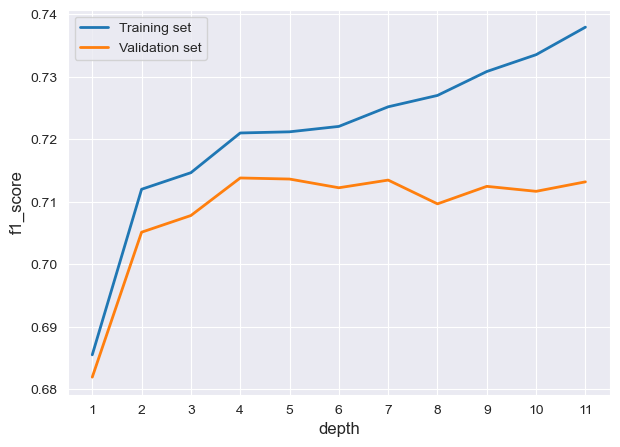


Best Model
--------------------------------------------------------------------------------

Validation Set
Best depth:  4
Best f1_score:  0.7138225758915413

Test Set
Accuracy:  0.7198499711482977
Precision:  0.7259439707673568
Recall:  0.6958552247518972
F1 score:  0.7105812220566318


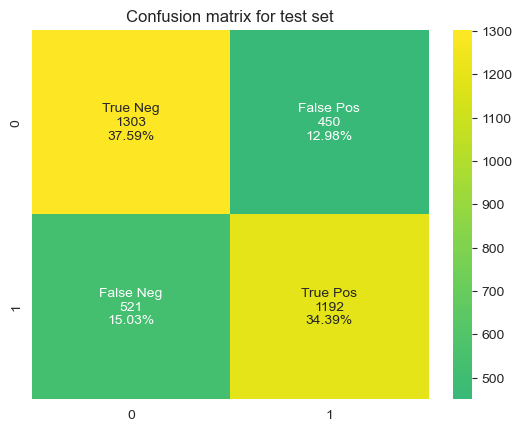

In [82]:
best_model_8 = determine_the_best_model(
                         X_train=X_train,
                         y_train=y_train,
                         X_val=X_val,
                         y_val=y_val,
                         X_test=X_test,
                         y_test=y_test,
                         depth_range=11,
                         main_metric='f1_score',
                         print_model=False,
                         plot_results=True,
                         plot_conf_matrix=True
                         )

Jak widać powyżej, wynik $F_1$ dla zbioru testowego jest znacząco mniejszy niż w poprzednim przypadku i wynosi **0,7105812**.

W przypadku zbyt małego zbioru treningowego np. gdy stanowi on jedynie **10%** wszystkich danych, model bardzo szybko ulega przetrenowaniu. Korzystając z tak małego zbióru treningowego, możemy domyślać się, że uzyskanie stosunkowo dobrego wyniku również w dużej mierze jest powiązane z doborem danych do znacznie większych zbiorów walidacyjnego i testowego, niekoniecznie musi wynikać to z odpowiednio wytrenowanego modelu.

Gdy podział został przeprowadzony w rozsądnych proporcjach, gdzie zbiór treningowy zawiera **60%** danych, natomiast zbiór walidacyjny i testowy po **20%**, rezulaty dla zbioru walidacyjnego i testowego są do siebie zbliżone, co pośrednio świadczy również o tym, że rozmiary zbiorów są odpowiednie.

Reasumując, o tym, jaka maksymalna głębokość drzewa jest tą optymalną, przy której uzyskujemy klasyfikator o najlepszej jakości, decyduje wiele czynników. Wśród nich jest z pewnością proporcja podziału dostępnych danych na zbiory treningowy, walidacyjny i testowy. Nie bez znaczenia jest także wybór miary wydajności, którą powinniśmy dobierać w zależności od tego, jaki aspekt problemu jest dla nas najważniejszy. Podczas ostatecznej oceny powinniśmy pamiętać również o czynniku losowym podczas podziału danych, co widzimy szczególnie gdy mamy do czynienia ze zbyt małymi, bądź zbyt dużymi zbiorami walidacyjnymi i testowymi względem zbioru treningowego.